# Imports and functions

In [424]:
import osmnx as ox
import networkx as nx
import folium
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np
import seaborn as sns

In [29]:
gdf = gpd.read_file("fietsnetwerk_nieuw.shp")
gdf = gdf.set_crs("EPSG:28992")
gdf.geometry

0       LINESTRING (110969.176 493694.990, 110973.765 ...
1       LINESTRING (110949.744 491726.470, 110959.941 ...
2       LINESTRING (111514.191 491261.463, 111438.099 ...
3       LINESTRING (111514.191 491261.463, 111685.463 ...
4       LINESTRING (111888.838 489131.349, 111919.176 ...
                              ...                        
5784    LINESTRING (122719.298 484486.670, 122728.064 ...
5785    LINESTRING (122809.332 484718.174, 122834.353 ...
5786    LINESTRING (122691.481 484643.569, 122687.186 ...
5787    LINESTRING (118494.707 487070.209, 118514.017 ...
5788    LINESTRING (118801.572 488410.256, 118815.855 ...
Name: geometry, Length: 5789, dtype: geometry

In [30]:
gdf = gdf.to_crs("EPSG:3857")

In [435]:
def shp_to_network(file_name, undirected=False, make_G_bidi=True, name="unnamed", amsterdam=False):
    gdf = gpd.read_file(file_name)
    gdf = gdf.explode()

    gdf = gdf.to_crs("EPSG:3857")
    gdf['Start_pos'] = gdf.geometry.apply(lambda x: x.coords[0])
    gdf['End_pos'] = gdf.geometry.apply(lambda x: x.coords[-1])
    gdf['length'] = gdf.length
    if amsterdam:
        gdf = gdf.set_crs("EPSG:28992")
        gdf = gdf.to_crs("EPSG:3857")
        gdf.loc[gdf.DIST.isna(), 'DIST'] = gdf.loc[gdf.DIST.isna(), 'length']

    # Create Series of unique nodes and their associated position
    s_points = gdf.Start_pos.append(gdf.End_pos).reset_index(drop=True)
    s_points = s_points.drop_duplicates()   
    #     log('GeoDataFrame has {} elements (linestrings) and {} unique nodes'.format(len(gdf),len(s_points)))

    # Add index of start and end node of linestring to geopandas DataFrame
    df_points = pd.DataFrame(s_points, columns=['Start_pos'])
    df_points['FNODE_'] = df_points.index
    gdf = pd.merge(gdf, df_points, on='Start_pos', how='inner')

    df_points = pd.DataFrame(s_points, columns=['End_pos'])
    df_points['TNODE_'] = df_points.index
    gdf = pd.merge(gdf, df_points, on='End_pos', how='inner')

    # Bring nodes and their position in form needed for osmnx (give arbitrary osmid (index) despite not osm file)
    df_points.columns = ['pos', 'osmid'] 
    df_points[['x', 'y']] = df_points['pos'].apply(pd.Series)
    df_node_xy = df_points.drop('pos', 1)

    # Create Graph Object
    G = nx.MultiDiGraph(name=name, crs=gdf.crs)

    # Add nodes to graph
    for node, data in df_node_xy.T.to_dict().items():
        G.add_node(node, **data)
        
    # Add edges to graph
    for i, row  in gdf.iterrows():
        dict_row  = row.to_dict()
        if 'geometry' in dict_row: del dict_row['geometry']
        # print(dict_row.keys())
        G.add_edge(u_for_edge=dict_row['FNODE_'], v_for_edge=dict_row['TNODE_'], **dict_row)
        
    if make_G_bidi:
        gdf.rename(columns={'Start_pos': 'End_pos',
                    'End_pos': 'Start_pos',
                    'FNODE_': 'TNODE_', 
                    'TNODE_': 'FNODE_', }, inplace=True)
        
        # Add edges to graph
        for i, row  in gdf.iterrows():
            dict_row  = row.to_dict()
            if 'geometry' in dict_row: del dict_row['geometry']
            G.add_edge(u_for_edge=dict_row['FNODE_'], v_for_edge=dict_row['TNODE_'], **dict_row)
    
    if undirected:
        G = G.to_undirected() # Some function in osmnx do not work anymore
    return G, gdf

# Loading data

## NYC

In [436]:
G_nyc, gdf_ny = shp_to_network("Bicycle Routes/nyc_bike.shp", name="nyc")

<ipython-input-435-18b810d0c2ba>:3: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  gdf = gdf.explode()


<AxesSubplot:>

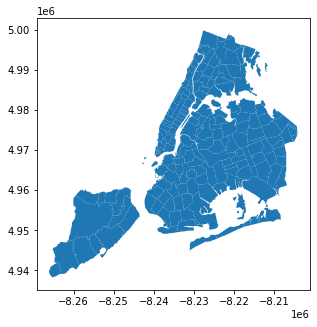

In [437]:
gdf_zip = gpd.read_file("ZIP_CODE_040114/ZIP_CODE_040114.shp")
gdf_zip = gdf_zip.to_crs("EPSG:3857")
gdf_zip.plot(figsize=(5,5))

In [438]:
gdf_ny = gdf_ny.to_crs("EPSG:3857")
gdf_joined_intersect = gdf_ny.sjoin(gdf_zip, predicate='intersects')
gdf_joined_intersect['close_length'] = gdf_joined_intersect.length
meters_per_zip = gdf_joined_intersect.groupby("ZIPCODE").close_length.sum()
meters_per_zip = meters_per_zip.reset_index()
gdf_zip = gdf_zip.merge(meters_per_zip, on='ZIPCODE', how="left")
gdf_zip.shape

(263, 14)

In [439]:
gdf_zip['bike_lanes_per_area'] = gdf_zip.close_length / gdf_zip.AREA * 1000
gdf_zip['bike_lanes_per_capita'] = gdf_zip.close_length / gdf_zip.POPULATION
gdf_zip.bike_lanes_per_capita = gdf_zip.bike_lanes_per_capita.fillna(0)
gdf_zip.loc[gdf_zip.bike_lanes_per_capita == np.inf, 'bike_lanes_per_capita'] = 0

## Amsterdam

In [177]:
G_ams, gdf_amsterdam = shp_to_network("fietsnetwerk_nieuw_2.shp", "amsterdam")

<ipython-input-176-5b74bf95b409>:5: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  gdf = gdf.explode()


In [178]:
gdf_pc = gpd.read_file("Amsterdam PC.json")
gdf_pc = gdf_pc.to_crs("EPSG:28992")
gdf_pc.shape

(80, 3)

In [179]:
gdf_amsterdam = gdf_amsterdam.to_crs("EPSG:3857")
gdf_ams_joined = gdf_amsterdam.sjoin(gdf_pc, predicate='intersects')
gdf_ams_joined['close_length'] = gdf_ams_joined.length
meters_per_pc = gdf_ams_joined.groupby("Postcode4").close_length.sum()
meters_per_pc = meters_per_pc.reset_index()
gdf_pc = gdf_pc.merge(meters_per_pc, on='Postcode4', how="left")
gdf_pc.shape

/Users/Lars/opt/anaconda3/lib/python3.8/site-packages/geopandas/geodataframe.py:1938: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3857
Right CRS: EPSG:28992

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)


(80, 4)

Add population

In [127]:
pop_df = pd.read_csv("bevolking_amsterdam.csv", delimiter=";")
pop_df = pop_df[['Postcode', 'Bevolking (aantal)']]
pop_df.head()

Postcode  Bevolking (aantal)
0      1011              9630.0
1      1012              8540.0
2      1013             21255.0
3      1014              2870.0
4      1015             14850.0

In [128]:
gdf_pc = gdf_pc.merge(pop_df, left_on="Postcode4", right_on="Postcode")
gdf_pc.shape

(80, 6)

In [129]:
gdf_pc['bike_lanes_per_area'] = gdf_pc.close_length / gdf_pc.area * 1000
gdf_pc['bike_lanes_per_capita'] = gdf_pc.close_length / gdf_pc['Bevolking (aantal)']
gdf_pc.loc[gdf_pc.bike_lanes_per_capita == np.inf, 'bike_lanes_per_capita'] = np.nan

# Visualisation
## Metrics per ZIP/PC

In [441]:
fig, ax = plt.subplots(2, 3, figsize=(30,20), dpi=500)

# gdf_pc.plot(ax=ax[0,0],column='close_length', legend=True)
# ax[0,0].set_title("Meters of bike lanes per ZIP code")

# gdf_pc.plot(ax=ax[0,1],column='bike_lanes_per_area', legend=True, scheme='quantiles', k = 10)
# ax[0,1].set_title("Meters of bike lanes per ZIP code (/ area)")

# gdf_pc.plot(ax=ax[0,2],column='bike_lanes_per_capita', legend=True, scheme='quantiles', k = 10)
# ax[0,2].set_title("Meters of bike lanes per ZIP code (/ population)")

gdf_zip.plot(ax=ax[1,0],column='close_length', legend=True)
ax[1,0].set_title("Meters of bike lanes per ZIP code")

gdf_zip.plot(ax=ax[1,1],column='bike_lanes_per_area', legend=True, scheme='jenkscaspallforced', k = 10)
ax[1,1].set_title("Meters of bike lanes per ZIP code (/ area)")

gdf_zip.plot(ax=ax[1,2],column='bike_lanes_per_capita', legend=True, scheme='jenkscaspallforced', k = 7)
ax[1,2].set_title("Meters of bike lanes per ZIP code (/ population)")


Text(0.5, 1.0, 'Meters of bike lanes per ZIP code (/ population)')

## Distribution of values

<AxesSubplot:xlabel='bike_lanes_per_capita', ylabel='Density'>

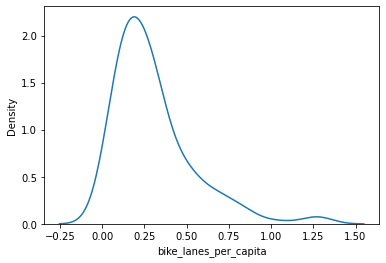

In [36]:
sns.kdeplot(gdf_zip[gdf_zip.bike_lanes_per_capita <= 2].bike_lanes_per_capita)

<AxesSubplot:xlabel='bike_lanes_per_capita', ylabel='Density'>

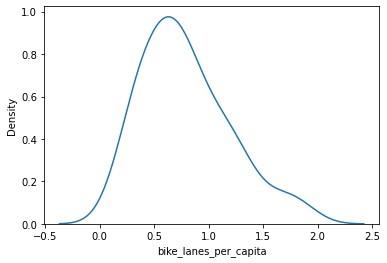

In [37]:
sns.kdeplot(gdf_pc[gdf_pc.bike_lanes_per_capita < 2].bike_lanes_per_capita)

<AxesSubplot:>

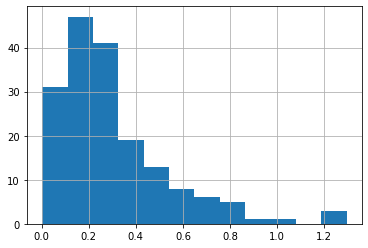

In [34]:
gdf_zip[gdf_zip.bike_lanes_per_capita <= 2].bike_lanes_per_capita.hist(bins=12)

<AxesSubplot:>

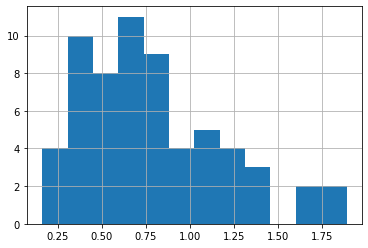

In [33]:
gdf_pc[gdf_pc.bike_lanes_per_capita < 2].bike_lanes_per_capita.hist(bins=12)

# Deviation of routes

### Drive

We need to find routes on both the bike as well as the road network. For the road network, we will load an `osmnx` graph with keyword `type=drive`. 

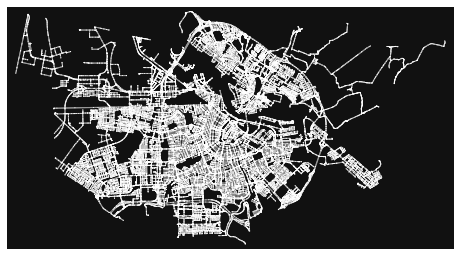

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [39]:
G_ams_drive = ox.graph_from_place(
    "Amsterdam, NL",
    network_type="drive",
    simplify=False
)
ox.plot_graph(
    G_ams_drive, 
    node_size=1,
)

In [40]:
start_cor = (52.3242503, 4.8731161)
end_cor = (52.3452294, 4.9221754)

In [41]:
start_node_drive = ox.get_nearest_node(G_ams_drive, start_cor)
end_node_drive = ox.get_nearest_node(G_ams_drive, end_cor)

(start_node_drive, end_node_drive)

/Users/Lars/opt/anaconda3/lib/python3.8/site-packages/osmnx/distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)
/Users/Lars/opt/anaconda3/lib/python3.8/site-packages/osmnx/distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)


(46176131, 46271209)

In [42]:
route_list_drive = nx.dijkstra_path(G_ams_drive, start_node_drive, end_node_drive)
route_length_drive = nx.dijkstra_path_length(G_ams_drive, start_node_drive, end_node_drive, weight='length')
round(route_length_drive)

6095

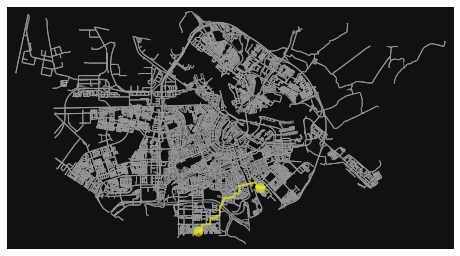

In [43]:
fig, ax = ox.plot_graph_route(G_ams_drive, route_list_drive, node_size=0, route_linewidth=2, route_color="yellow")

### Bike

In [180]:
G_ams = nx.MultiDiGraph(G_ams)

In [181]:
# G_ams.graph["crs"] = "EPSG:28992"
G_ams.graph["crs"]

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [182]:
start_node_bike = ox.get_nearest_node(G_ams, start_cor)
end_node_bike = ox.get_nearest_node(G_ams, end_cor)

(start_node_bike, end_node_bike)

/Users/Lars/opt/anaconda3/lib/python3.8/site-packages/osmnx/distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)


(11069, 11069)

In [183]:
G_ams_consol = ox.consolidate_intersections(G_ams)

<ipython-input-183-bcdb7a8d439f>:1: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  G_ams_consol = ox.consolidate_intersections(G_ams)


In [184]:
route_list_bike = nx.shortest_path(G_ams_consol, 4097, 3483)
route_length_bike = nx.dijkstra_path_length(G_ams_consol, 4097, 3483, weight='length')
round(route_length_bike)

7613

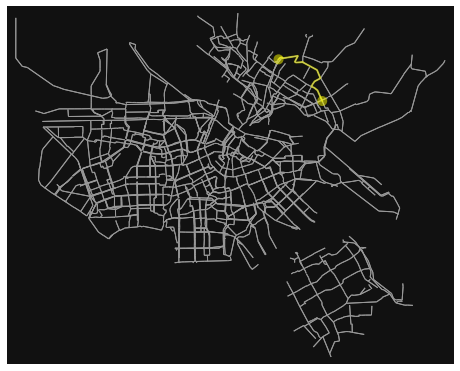

In [185]:
# fig, ax = plt.subplots(figsize=(10,10), dpi=500)

fig, ax = ox.plot_graph_route(G_ams_consol, route_list_bike, node_size=0, route_linewidth=2, route_color="yellow")

In [186]:
node_list = [node for node in G_ams_consol.nodes]
len(node_list)

5186

Find edges that exist

In [187]:
np.random.choice(node_list)

4213

In [188]:
nx.has_path(G_ams_consol, 928, 149)

True

In [193]:

def find_existing_paths(G, n=100):
    paths = []
    for i in range(n):
        counter = 0
        start_node = np.random.choice(node_list)
        has_path = False
        end_node = None
        while has_path == False:
            counter += 1
            if counter == 15:
                start_node = np.random.choice(node_list)
            end_node = np.random.choice(node_list)
            has_path = nx.has_path(G_ams_consol, start_node, end_node)
        paths.append((start_node, end_node))
    return paths

In [401]:
valid = [7, 8, 13, 19, 20, 22, 23, 24, 27, 28, 29, 38, 47, 56, 59, 61, 70, 73, 81, 98]

In [405]:
valid_paths = [n for i, n in enumerate(paths) if i in valid]

In [408]:
all_routes = []
for path in valid_paths:
    all_routes.append(nx.dijkstra_path(G_ams_consol, path[0], path[1], weight='DIST'))

len(all_routes)

20

In [421]:
valid_paths

[(1158, 2972),
 (69, 520),
 (2357, 2223),
 (3692, 2903),
 (896, 1840),
 (4838, 157),
 (3373, 2176),
 (744, 3530),
 (3242, 2316),
 (4594, 1675),
 (3239, 2898),
 (4472, 2889),
 (4070, 2079),
 (900, 2865),
 (2960, 3356),
 (4852, 720),
 (1111, 29),
 (2302, 3055),
 (4206, 1945),
 (2404, 300)]

In [237]:
i = 21

In [400]:
route_list_bike = nx.dijkstra_path(G_ams_consol, paths[i][0], paths[i][1], weight='DIST')
route_length_bike = nx.dijkstra_path_length(G_ams_consol, paths[i][0], paths[i][1], weight='DIST')
round(route_length_bike)
print(i)
i += 1

IndexError: list index out of range

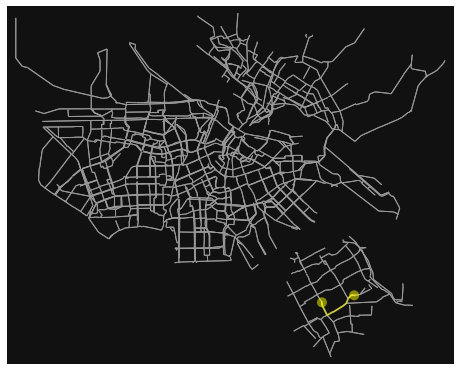

In [399]:
# fig, ax = plt.subplots(figsize=(10,10), dpi=500)

fig, ax = ox.plot_graph_route(G_ams_consol, route_list_bike, node_size=0, route_linewidth=2, route_color="yellow")

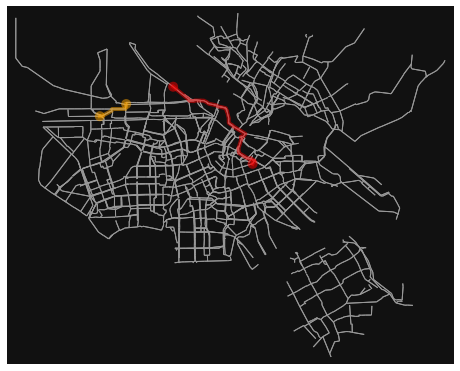

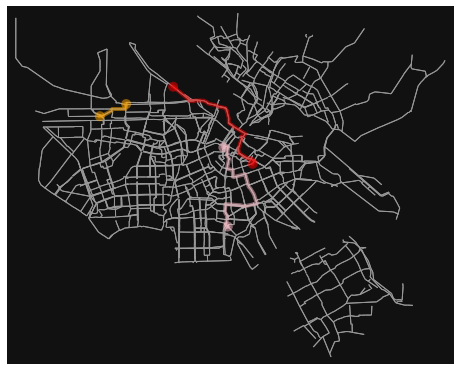

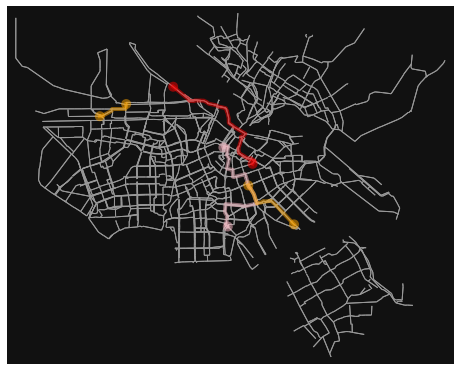

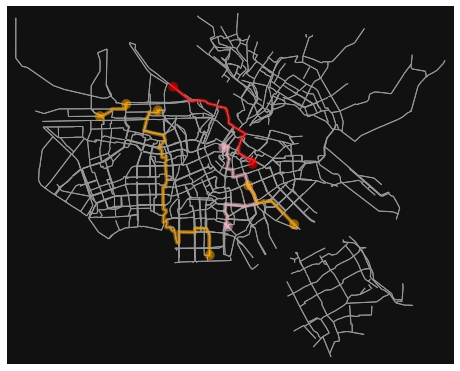

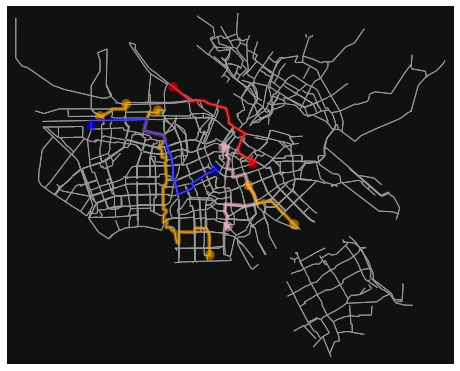

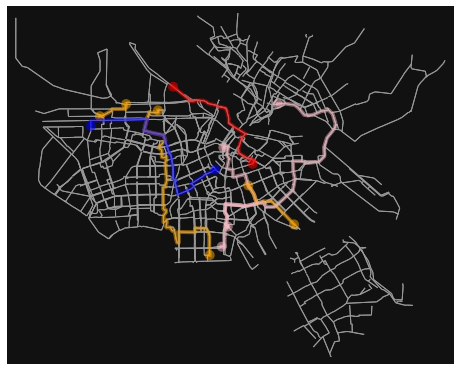

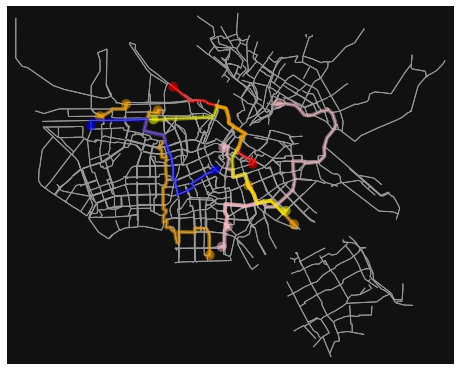

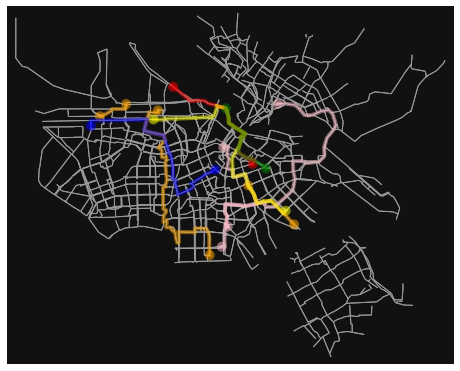

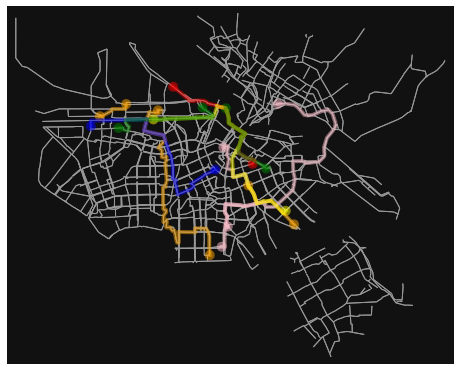

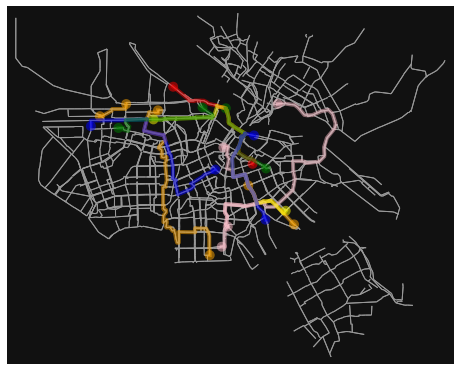

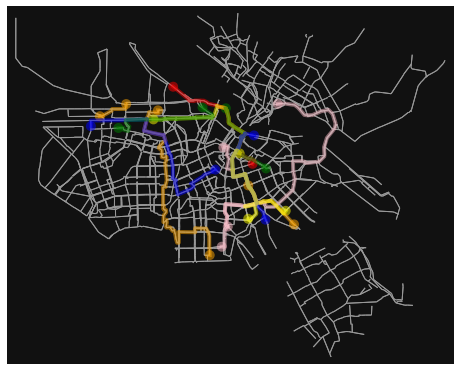

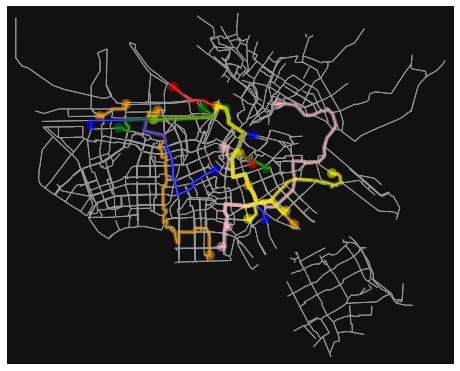

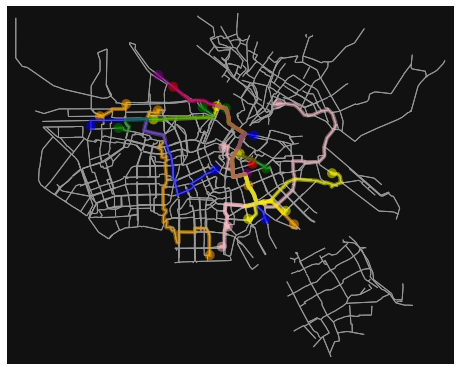

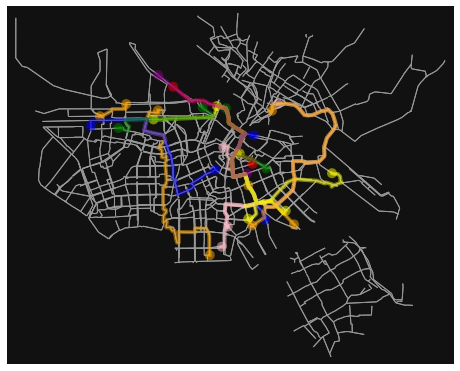

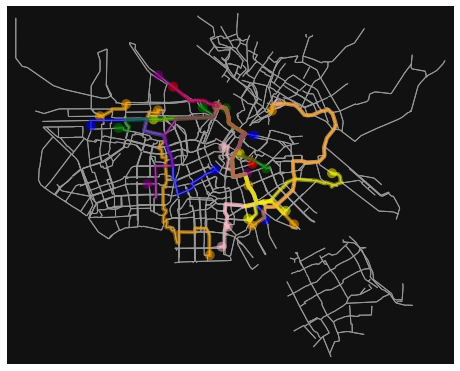

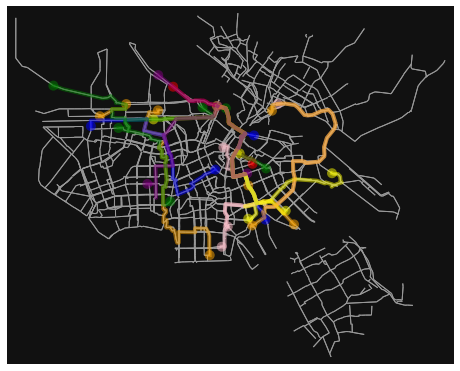

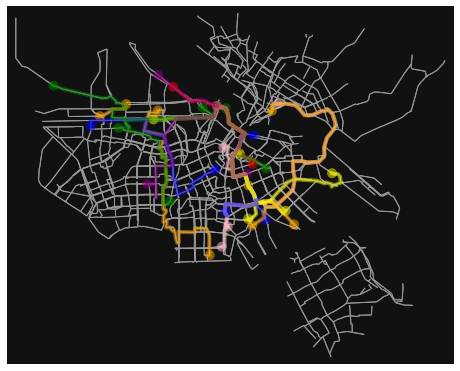

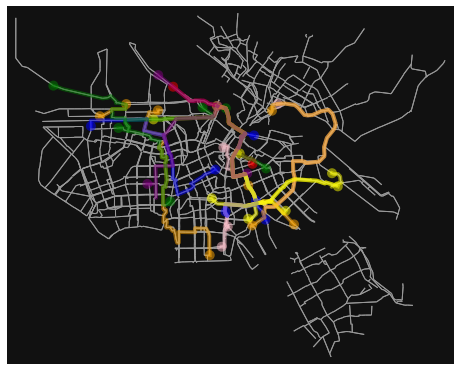

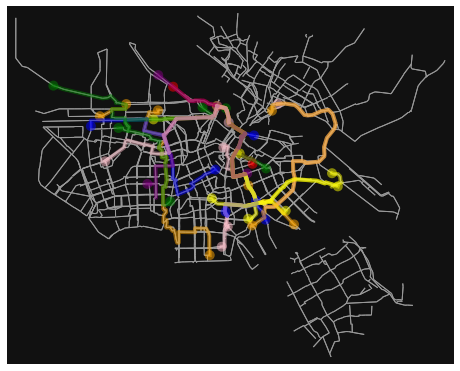

ValueError: route_colors list must have same length as routes

In [418]:
# fig, ax = plt.subplots(figsize=(10,10), dpi=500)

choose_colors = ['yellow', 'red', 'green', 'blue', 'pink', 'purple', 'orange']
route_colors = ['red']

for i in range(len(all_routes)):
    color = np.random.choice(choose_colors)
    route_colors.append(color)
    fig, ax = ox.plot_graph_routes(G_ams_consol, all_routes[:i+2], node_size=0, route_linewidth=2, route_colors=route_colors)
    fig.savefig("amsterdam_" + str(i) + ".png")

3136


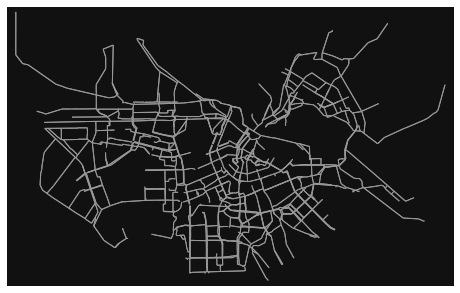

In [200]:
Gc = ox.utils_graph.get_largest_component(G_ams_consol, strongly=True)
print(len(Gc)) #9503
fig, ax = ox.plot_graph(Gc, node_size=0)

In [201]:
nodes = [y for x in nx.strongly_connected_components(G_ams_consol) if len(x) > 1 for y in x]
Gc = ox.utils_graph.induce_subgraph(G_ams_consol, nodes)
print(len(Gc)) #9551
fig, ax = ox.plot_graph(Gc, node_size=0)

AttributeError: module 'osmnx.utils_graph' has no attribute 'induce_subgraph'

# Building graph

## Using other shapefile

In [582]:
gdf_alt = gpd.read_file("CSCL/geo_export_4f5b5695-84f7-40f1-b3eb-63eadaca7397.shp")
gdf_alt.shape

(120207, 34)

In [583]:
gdf_alt['bike_lane'] = pd.to_numeric(gdf_alt.bike_lane)

In [584]:
gdf_alt = gdf_alt.to_crs("EPSG:3857")

In [585]:
gdf_alt = gdf_alt.sjoin(gdf_zip, predicate='intersects')
gdf_alt['close_length'] = gdf_alt.length
gdf_alt.shape

(127200, 50)

In [586]:
all_ZIPS = gdf_alt.ZIPCODE.unique()
len(all_ZIPS)

196

In [587]:
gdf_alt['edited'] = False
gdf_alt.shape

(127200, 51)

<AxesSubplot:>

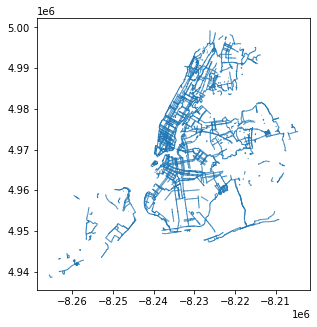

In [588]:
fig, ax = plt.subplots(figsize=(5, 5))

gdf_alt[gdf_alt.bike_lane >= 1].plot(ax=ax, linewidth=1)

In [589]:
gdf_alt = gdf_alt.reset_index()

In [590]:
gdf_alt_ = gdf_alt.copy()

In [732]:
def find_lane_by_ZIP(gdf, ZIP_code, random=False):
    ZIP_sub = gdf[gdf.ZIPCODE == ZIP_code]
    print("ZIP_sub", ZIP_sub.shape)
    potential_roads = ZIP_sub[ZIP_sub.bike_lane.isna()]
    print("Pot roads", potential_roads.shape)
    if potential_roads.shape[0] > 0:
        if random:
            index = np.random.choice(potential_roads.index)
        else:
            total_bike_lanes = gdf_alt_[gdf_alt_.bike_lane >= 1]
            potential_roads_dist = ckdnearest(potential_roads, total_bike_lanes)
            potential_roads_dist = potential_roads_dist.drop('close_length', axis = 1)
            potential_roads_dist.index = potential_roads.index
            potential_roads_dist.loc[:, 'close_length'] = potential_roads.close_length
            # index = potential_roads_dist.sort_values(by=["dist", "close_length"], ascending=(True, False)).index[0]
            index = potential_roads_dist.sort_values(by="dist", ascending=True).index[0]
        gdf.loc[index, 'bike_lane'] = 1
        gdf.loc[index, 'edited'] = True
    return gdf

In [ ]:
from scipy.spatial import cKDTree

def ckdnearest(gdA, gdB, start=True):
    if start:
        nA = np.array(list(gdA.geometry.apply(lambda x: (x.coords[0][0], x.coords[0][1]))))
        nB = np.array(list(gdB.geometry.apply(lambda x: (x.coords[0][0], x.coords[0][1]))))
    else:
        nA = np.array(list(gdA.geometry.apply(lambda x: (x.coords[-1][0], x.coords[-1][1]))))
        nB = np.array(list(gdB.geometry.apply(lambda x: (x.coords[-1][0], x.coords[-1][1]))))
    btree = cKDTree(nB)
    dist, idx = btree.query(nA, k=1)
    gdB_nearest = gdB.iloc[idx].drop(columns="geometry").reset_index(drop=True)
    gdf = pd.concat(
        [
            gdA.reset_index(drop=True),
            gdB_nearest,
            pd.Series(dist, name='dist')
        ], 
        axis=1)

    return gdf

In [725]:
def fill_ZIP(gdf, ZIP_code, value, metric="bike_lanes_per_capita"):
    if metric == "bike_lanes_per_capita":
        new_value = 0
        while new_value < value:
            old_value = gdf[
                (gdf.ZIPCODE == ZIP_code) &
                (gdf.bike_lane >= 1)
            ].close_length.sum() / gdf[gdf.ZIPCODE == ZIP_code].POPULATION.median()
            print("Old value", old_value)
            gdf = find_lane_by_ZIP(gdf, ZIP_code)
            new_value = gdf[
                (gdf.ZIPCODE == ZIP_code) &
                (gdf.bike_lane >= 1)
            ].close_length.sum() / gdf[gdf.ZIPCODE == ZIP_code].POPULATION.median()
            print("New value", new_value)

    elif metric == "bike_lanes_per_area":
        pass
    return gdf, new_value

In [606]:
gdf_alt_ = gdf_alt.copy()
gdf_alt_ = fill_ZIP(gdf_alt_, all_ZIPS[2], 2)

Old value 0.750427703693836
ZIP_sub (727, 52)
Pot roads (514, 52)
New value 0.7565421557443559
Old value 0.7565421557443559
ZIP_sub (727, 52)
Pot roads (513, 52)
New value 0.7596986769192902
Old value 0.7596986769192902
ZIP_sub (727, 52)
Pot roads (512, 52)
New value 0.7606605689273093
Old value 0.7606605689273093
ZIP_sub (727, 52)
Pot roads (511, 52)
New value 0.7632721170929164
Old value 0.7632721170929164
ZIP_sub (727, 52)
Pot roads (510, 52)
New value 0.7661169399438162
Old value 0.7661169399438162
ZIP_sub (727, 52)
Pot roads (509, 52)
New value 0.7671631872163317
Old value 0.7671631872163317
ZIP_sub (727, 52)
Pot roads (508, 52)
New value 0.7734842990919913
Old value 0.7734842990919913
ZIP_sub (727, 52)
Pot roads (507, 52)
New value 0.7770790167559221
Old value 0.7770790167559221
ZIP_sub (727, 52)
Pot roads (506, 52)
New value 0.7829162695557285
Old value 0.7829162695557285
ZIP_sub (727, 52)
Pot roads (505, 52)
New value 0.7897074288119046
Old value 0.7897074288119046
ZIP_sub (727

In [611]:
all_ZIPS[2]

'11231'

<AxesSubplot:>

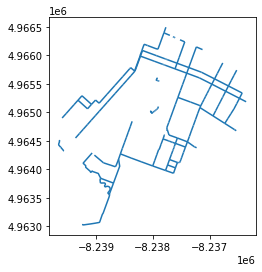

In [607]:
gdf_alt[(gdf_alt.ZIPCODE == all_ZIPS[2]) & (gdf_alt.bike_lane >= 1)].plot()

<AxesSubplot:>

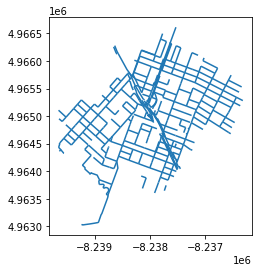

In [609]:
gdf_alt_[(gdf_alt_.ZIPCODE == all_ZIPS[2]) & (gdf_alt_.bike_lane >= 1)].plot()

In [734]:
iteration = 1

def fill_all_zips(gdf, metric="bike_lanes_per_capita", target=2):
    i = 0
    per_cap = gdf[gdf.bike_lane >= 1].groupby("ZIPCODE").close_length.sum() / gdf.groupby("ZIPCODE").POPULATION.median()
    per_cap = per_cap[(per_cap.notna()) & (per_cap < np.inf)]
    per_cap = per_cap[per_cap < 2]
    valid_zips = list(per_cap.index)
    while valid_zips:
        i += 1
        work_on = np.random.choice(valid_zips)
        gdf = find_lane_by_ZIP(gdf, work_on)
        value = gdf[
                (gdf.ZIPCODE == work_on) &
                (gdf.bike_lane >= 1)
        ].close_length.sum() / gdf[gdf.ZIPCODE == work_on].POPULATION.median()
        print(work_on, value)
        if value >= target:
            print("Removing:", work_on)
            valid_zips.remove(work_on)
        if i % 150 == 0:
            fig, ax = plt.subplots(figsize=(10, 10), dpi=600)
            gdf[(gdf_alt_.bike_lane >= 1)].plot(ax=ax, linewidth=0.5, column='edited', cmap='coolwarm')
            fig.savefig("New York_" + str(iteration) + "_" + str(i) + ".png")
            plt.close(fig)
    

In [735]:
iteration += 1
gdf_alt_ = gdf_alt.copy()
fill_all_zips(gdf_alt_)

ZIP_sub (788, 52)
Pot roads (753, 52)
10310 0.2428332069264198
ZIP_sub (599, 52)
Pot roads (578, 52)
11219 0.026388240437029857
ZIP_sub (220, 52)
Pot roads (168, 52)
10128 0.14070748201080574
ZIP_sub (92, 52)
Pot roads (84, 52)
10006 0.08072158800640505
ZIP_sub (370, 52)
Pot roads (280, 52)
10016 0.19109843277716881
ZIP_sub (308, 52)
Pot roads (274, 52)
10470 0.28250925302593577
ZIP_sub (346, 52)
Pot roads (308, 52)
11004 0.42930473225310356
ZIP_sub (281, 52)
Pot roads (210, 52)
11104 0.3173933936784495
ZIP_sub (1124, 52)
Pot roads (986, 52)
11364 0.8048191294680164
ZIP_sub (370, 52)
Pot roads (279, 52)
10016 0.19298542092947396
ZIP_sub (308, 52)
Pot roads (223, 52)
10034 0.3992021902682522
ZIP_sub (453, 52)
Pot roads (436, 52)
11428 0.09709490628280623
ZIP_sub (844, 52)
Pot roads (636, 52)
10452 0.24197529831496972
ZIP_sub (71, 52)
Pot roads (62, 52)
11005 0.5397403644347808
ZIP_sub (640, 52)
Pot roads (536, 52)
10456 0.13081730148847542
ZIP_sub (704, 52)
Pot roads (635, 52)
11369 0.1

KeyboardInterrupt: 

In [641]:
per_cap = gdf_alt[gdf_alt.bike_lane >= 1].groupby("ZIPCODE").close_length.sum() / gdf_alt.groupby("ZIPCODE").POPULATION.median()
per_cap = per_cap[(per_cap.notna()) & (per_cap < np.inf)]
per_cap = per_cap[per_cap < 2]
valid_zips = list(per_cap.index)

gdf_alt.

## Test

In [463]:
random_sample = np.round(np.random.uniform(0, 100, (1, 100))[0])
gdf_test = gdf_ny.loc[random_sample]
gdf_test.shape

(100, 22)

In [465]:
gdf_ny.shape

(19877, 22)

In [466]:
gpd.overlay(gdf_ny, gdf_test, how='difference').shape

(19813, 22)

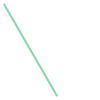

In [449]:
gdf_ny.loc[0].geometry

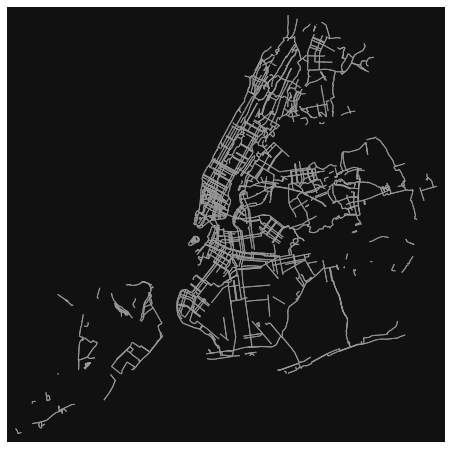

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [444]:
ox.plot_graph(G_nyc, node_size=0)